In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from metrics import MCC

In [2]:
# Model name used to save the weights in h5 format. The name match with the Jupyter notebook
now = datetime.datetime.now()

MODEL_NAME = 'malaria_model_' + now.strftime('%Y%m%d%H%M')
print(MODEL_NAME)

malaria_model_201906181822


In [3]:
# DATA PATHS

TRAIN_FOLDER_PATH = '../../data/train/'
VAL_FODLER_PATH = '../../data/validation/'
#TEST_FOLDER_PATH = '../../data/test/'
TEST_FOLDER_PATH = '../../data/test_manual'
PREVIEW_IMAGES_FOLDER = '../../data/preview/'

PREDICTION_FILE_PATH = '../../data/' + MODEL_NAME + '.csv'

In [4]:
# Configure hyperparameters
img_width = 130
img_height = 130
img_depth = 3

classes = 2
batch_size = 64
num_epochs = 60
loss = "categorical_crossentropy"
learning_rate = 1e-1
decay = 1e-1
momentum = 0.9

In [5]:
# MODEL TRAINING CONFIGURATION

train_datagen = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_FOLDER_PATH,
    target_size = (img_height,img_width),
    color_mode='rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

validation_generator = validation_datagen.flow_from_directory(
    VAL_FODLER_PATH,
    target_size = (img_height, img_width),
    color_mode='rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

test_generator = test_datagen.flow_from_directory(
    TEST_FOLDER_PATH,
    target_size = (img_height, img_width),
    color_mode='rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 20668 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Found 1376 images belonging to 2 classes.


In [6]:
# Model architecture

inputShape = (img_height, img_width, img_depth)

model = Sequential()

model.add(Conv2D(32, (3,3), padding="same", input_shape=(img_width, img_height, img_depth)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))

model.add(GlobalAveragePooling2D())
model.add(Dense(classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 130, 130, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 130, 130, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 65, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 65, 65, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 65, 65, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 65, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 65, 65, 64)        0

In [8]:
# Callbacks
mc = ModelCheckpoint('best_' + MODEL_NAME + '.h5', monitor='val_MCC', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor = 'val_MCC', patience=10, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(patience=2)

In [10]:
# Compile the model
opt = SGD(lr=learning_rate, momentum=momentum, decay=decay / num_epochs)

model.compile(loss=loss, optimizer = opt, metrics=["accuracy", MCC])

In [11]:
# Fit the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n // train_generator.batch_size,
    epochs = num_epochs,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // validation_generator.batch_size,
    use_multiprocessing = False,
    workers=1,
    callbacks = [mc, es]
)

Epoch 1/60


W0618 18:23:12.322127 140692662204224 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


321/322 [============================>.] - ETA: 0s - loss: 0.6814 - accuracy: 0.5789 - MCC: 0.1577
Epoch 00001: val_MCC improved from -inf to -0.00109, saving model to best_malaria_model_201906181822.h5
322/322 [==============================] - 65s 201ms/step - loss: 0.6815 - accuracy: 0.5784 - MCC: 0.1568 - val_loss: 0.6946 - val_accuracy: 0.4995 - val_MCC: -0.0011
Epoch 2/60
321/322 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.5003 - MCC: 6.9444e-04
Epoch 00002: val_MCC did not improve from -0.00109
322/322 [==============================] - 63s 196ms/step - loss: 0.6941 - accuracy: 0.5002 - MCC: 4.9819e-04 - val_loss: 0.6994 - val_accuracy: 0.4995 - val_MCC: -0.0011
Epoch 3/60
321/322 [============================>.] - ETA: 0s - loss: 0.6807 - accuracy: 0.5478 - MCC: 0.0955
Epoch 00003: val_MCC improved from -0.00109 to 0.01853, saving model to best_malaria_model_201906181822.h5
322/322 [==============================] - 63s 195ms/step - loss: 0.6807 - ac

321/322 [============================>.] - ETA: 0s - loss: 0.1283 - accuracy: 0.9594 - MCC: 0.9188
Epoch 00024: val_MCC did not improve from 0.92369
322/322 [==============================] - 63s 196ms/step - loss: 0.1284 - accuracy: 0.9593 - MCC: 0.9187 - val_loss: 0.1275 - val_accuracy: 0.9593 - val_MCC: 0.9186
Epoch 25/60
321/322 [============================>.] - ETA: 0s - loss: 0.1293 - accuracy: 0.9573 - MCC: 0.9146
Epoch 00025: val_MCC did not improve from 0.92369
322/322 [==============================] - 63s 195ms/step - loss: 0.1295 - accuracy: 0.9572 - MCC: 0.9145 - val_loss: 0.1271 - val_accuracy: 0.9613 - val_MCC: 0.9226
Epoch 26/60
321/322 [============================>.] - ETA: 0s - loss: 0.1254 - accuracy: 0.9579 - MCC: 0.9159
Epoch 00026: val_MCC did not improve from 0.92369
322/322 [==============================] - 63s 196ms/step - loss: 0.1252 - accuracy: 0.9580 - MCC: 0.9160 - val_loss: 0.1259 - val_accuracy: 0.9595 - val_MCC: 0.9190
Epoch 27/60
321/322 [==========

321/322 [============================>.] - ETA: 0s - loss: 0.1129 - accuracy: 0.9619 - MCC: 0.9239
Epoch 00048: val_MCC did not improve from 0.92951
322/322 [==============================] - 61s 189ms/step - loss: 0.1128 - accuracy: 0.9619 - MCC: 0.9238 - val_loss: 0.1223 - val_accuracy: 0.9638 - val_MCC: 0.9277
Epoch 49/60
321/322 [============================>.] - ETA: 0s - loss: 0.1129 - accuracy: 0.9613 - MCC: 0.9227
Epoch 00049: val_MCC did not improve from 0.92951
322/322 [==============================] - 61s 189ms/step - loss: 0.1129 - accuracy: 0.9614 - MCC: 0.9228 - val_loss: 0.1193 - val_accuracy: 0.9598 - val_MCC: 0.9197
Epoch 50/60
321/322 [============================>.] - ETA: 0s - loss: 0.1156 - accuracy: 0.9615 - MCC: 0.9231
Epoch 00050: val_MCC did not improve from 0.92951
322/322 [==============================] - 61s 189ms/step - loss: 0.1157 - accuracy: 0.9616 - MCC: 0.9231 - val_loss: 0.1138 - val_accuracy: 0.9648 - val_MCC: 0.9295
Epoch 51/60
321/322 [==========

In [17]:
# Save model
model.save_weights(MODEL_NAME + '.h5')

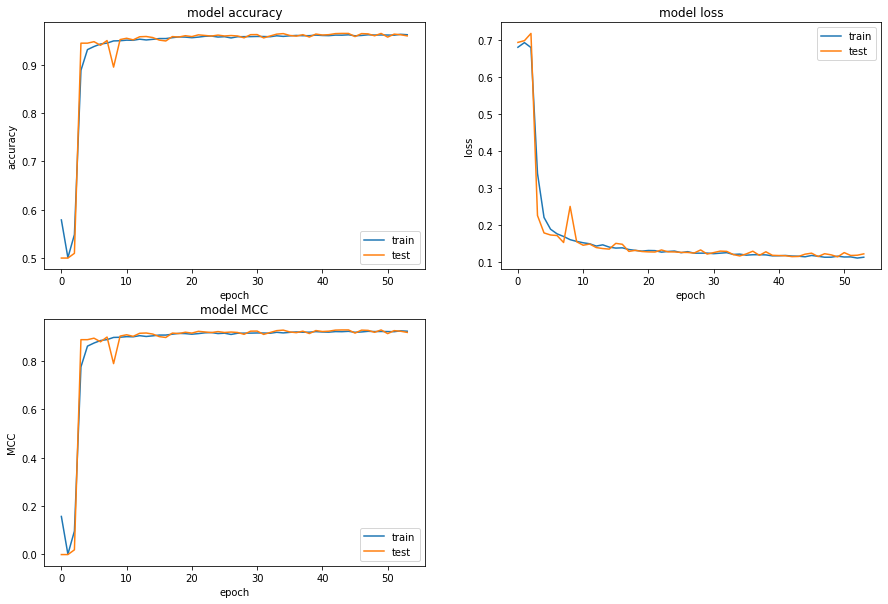

In [18]:
# Plot accuracy and loss values
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
#plt.show()
# summarize history for loss
plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# Plot MCC values
plt.subplot(2,2,3)
plt.plot(history.history['MCC'])
plt.plot(history.history['val_MCC'])
plt.title('model MCC')
plt.ylabel('MCC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [19]:
# Evaluate the model
model.evaluate_generator(validation_generator, steps = validation_generator.n // validation_generator.batch_size)

[0.12191067729145288, 0.9596657, 0.9193314]

In [20]:
# Predictions

test_generator.reset()
predIdxs = model.predict_generator(test_generator,steps=(test_generator.n // test_generator.batch_size) + 1)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [21]:
# Show metrics

print(classification_report(test_generator.classes, predIdxs, target_names=test_generator.class_indices.keys()))

cm = confusion_matrix(test_generator.classes, predIdxs)
total = sum(sum(cm))
acc = (cm[0,0] + cm[1,1]) / total
sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
specificity = cm[1,1] / (cm[1,0] + cm[1,1])

print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

              precision    recall  f1-score   support

 parasitized       0.99      0.93      0.96       688
  uninfected       0.93      0.99      0.96       688

    accuracy                           0.96      1376
   macro avg       0.96      0.96      0.96      1376
weighted avg       0.96      0.96      0.96      1376

acc: 0.9586
sensitivity: 0.9288
specificity: 0.9884
